## IR2 Customized Prediction Time Series Model

In [3]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker-ir2"  # change to your desired S3 prefix
region = sess.boto_region_name

role = sagemaker.get_execution_role()

In [4]:
import boto3
import io
import json
import time

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd

import s3fs
import gzip

In [5]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# download the data
s3 = boto3.client("s3")
datafile = "consumables.csv"
s3.download_file(
    "sagemaker-ir2",
    "Dataset/gl-level/consumables.csv",
    datafile,
)

# # show readme
# display(Markdown("README.md"))

# read the input file, and display sample rows/columns
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 50)
dfc = pd.read_csv(datafile, encoding='latin-1')


dfc.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,GL_PRODUCT_GROUP,PRODUCT_CATEGORY_CODE,TIME_PERIOD,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_ORDER_UNITS,DDAA_GROSS_SHIP_GMS,DDAA_GROSS_SHIP_UNITS
0,194.0,19401100,2022-05-09,8.021057e+06,233526.0,7.657874e+06,231768.0,8.014605e+06,381730.270000,8.135858e+06,237869.0,8.038382e+06,232865.0
1,370.0,37000100,2022-05-09,5.198169e+06,388293.0,5.106204e+06,382515.0,5.194338e+06,19931.270000,5.202204e+06,388602.0,5.126354e+06,382770.0
2,194.0,19409500,2022-05-09,2.997970e+05,15291.0,2.739610e+05,15051.0,3.023049e+05,24912.597927,3.050406e+05,15627.0,2.987258e+05,15131.0
3,325.0,32509000,2022-05-09,3.273955e+05,34754.0,3.054216e+05,33088.0,3.307602e+05,3563.490000,3.399752e+05,35370.0,3.089775e+05,33154.0
4,121.0,12108800,2022-05-09,2.217893e+04,18693.0,2.228757e+04,21037.0,4.237197e+05,427.460000,2.284376e+04,18706.0,2.271503e+04,21144.0


In [5]:
# # download the data
# s3 = boto3.client("s3")
# datafile = "data.csv"
# s3.download_file(
#     "broadwayinsightsmodelparams-dataaggregationbucket-1wi5vjqbuzwnp",
#     "ir2-custom-prediction/region=NA/productfamily=Consumables/data.csv",
#     datafile,
# )

# # # show readme
# # display(Markdown("README.md"))

# # read the input file, and display sample rows/columns
# pd.set_option("display.max_columns", 500)
# pd.set_option("display.max_rows", 50)
# dfc = pd.read_csv(datafile, encoding='latin-1')
# dfc.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,GL_PRODUCT_GROUP,PRODUCT_CATEGORY_CODE,TIME_PERIOD,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_ORDER_UNITS,DDAA_GROSS_SHIP_GMS,DDAA_GROSS_SHIP_UNITS
0,194.0,19401100,2022-05-09,8.021057e+06,233526.0,7.657874e+06,231768.0,8.014605e+06,381730.270000,8.135858e+06,237869.0,8.038382e+06,232865.0
1,370.0,37000100,2022-05-09,5.198169e+06,388293.0,5.106204e+06,382515.0,5.194338e+06,19931.270000,5.202204e+06,388602.0,5.126354e+06,382770.0
2,194.0,19409500,2022-05-09,2.997970e+05,15291.0,2.739610e+05,15051.0,3.023049e+05,24912.597927,3.050406e+05,15627.0,2.987258e+05,15131.0
3,325.0,32509000,2022-05-09,3.273955e+05,34754.0,3.054216e+05,33088.0,3.307602e+05,3563.490000,3.399752e+05,35370.0,3.089775e+05,33154.0
4,121.0,12108800,2022-05-09,2.217893e+04,18693.0,2.228757e+04,21037.0,4.237197e+05,427.460000,2.284376e+04,18706.0,2.271503e+04,21144.0


,GL_PRODUCT_GROUP,PRODUCT_CATEGORY_CODE,TIME_PERIOD,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_ORDER_UNITS,DDAA_GROSS_SHIP_GMS,DDAA_GROSS_SHIP_UNITS
0,194.0,19401100,2022-05-09,8.021057e+06,233526.0,7.657874e+06,231768.0,8.014605e+06,381730.270000,8.135858e+06,237869.0,8.038382e+06,232865.0
1,370.0,37000100,2022-05-09,5.198169e+06,388293.0,5.106204e+06,382515.0,5.194338e+06,19931.270000,5.202204e+06,388602.0,5.126354e+06,382770.0
2,194.0,19409500,2022-05-09,2.997970e+05,15291.0,2.739610e+05,15051.0,3.023049e+05,24912.597927,3.050406e+05,15627.0,2.987258e+05,15131.0
3,325.0,32509000,2022-05-09,3.273955e+05,34754.0,3.054216e+05,33088.0,3.307602e+05,3563.490000,3.399752e+05,35370.0,3.089775e+05,33154.0
4,121.0,12108800,2022-05-09,2.217893e+04,18693.0,2.228757e+04,21037.0,4.237197e+05,427.460000,2.284376e+04,18706.0,2.271503e+04,21144.0


In [6]:
dfc.shape

(73570, 13)

(73570, 13)

In [7]:
print(dfc.TIME_PERIOD.min())
print(dfc.TIME_PERIOD.max())
print(dfc.GL_PRODUCT_GROUP.max())

2018-04-30
2022-05-09
751.0


In [8]:
# create a new column as target, represent Net GMS
dfc['Net_GMS'] = dfc['DDAA_SHIP_GMS'] - dfc['DDAA_REFUNDED_AMOUNT']


In [9]:
dfc.dtypes

GL_PRODUCT_GROUP                float64
PRODUCT_CATEGORY_CODE            object
TIME_PERIOD                      object
DDAA_ORDER_GMS                  float64
TOTAL_ORDERED_UNITS             float64
DDAA_SHIP_GMS                   float64
DDAA_SHIP_UNITS                 float64
TOTAL_ORDERED_PROD_SALES_AMT    float64
DDAA_REFUNDED_AMOUNT            float64
DDAA_GROSS_ORDER_GMS            float64
DDAA_GROSS_ORDER_UNITS          float64
DDAA_GROSS_SHIP_GMS             float64
DDAA_GROSS_SHIP_UNITS           float64
Net_GMS                         float64
dtype: object

In [10]:
dfc.GL_PRODUCT_GROUP = dfc.GL_PRODUCT_GROUP.astype(object)

In [11]:
dfc.dtypes

GL_PRODUCT_GROUP                 object
PRODUCT_CATEGORY_CODE            object
TIME_PERIOD                      object
DDAA_ORDER_GMS                  float64
TOTAL_ORDERED_UNITS             float64
DDAA_SHIP_GMS                   float64
DDAA_SHIP_UNITS                 float64
TOTAL_ORDERED_PROD_SALES_AMT    float64
DDAA_REFUNDED_AMOUNT            float64
DDAA_GROSS_ORDER_GMS            float64
DDAA_GROSS_ORDER_UNITS          float64
DDAA_GROSS_SHIP_GMS             float64
DDAA_GROSS_SHIP_UNITS           float64
Net_GMS                         float64
dtype: object

In [12]:
dfc.isnull().sum()

GL_PRODUCT_GROUP                0
PRODUCT_CATEGORY_CODE           0
TIME_PERIOD                     0
DDAA_ORDER_GMS                  0
TOTAL_ORDERED_UNITS             0
DDAA_SHIP_GMS                   0
DDAA_SHIP_UNITS                 0
TOTAL_ORDERED_PROD_SALES_AMT    0
DDAA_REFUNDED_AMOUNT            0
DDAA_GROSS_ORDER_GMS            0
DDAA_GROSS_ORDER_UNITS          0
DDAA_GROSS_SHIP_GMS             0
DDAA_GROSS_SHIP_UNITS           0
Net_GMS                         0
dtype: int64

In [13]:
dfc['month'] = pd.DatetimeIndex(dfc['TIME_PERIOD']).month
dfc['TIME_PERIOD'] = pd.to_datetime(dfc['TIME_PERIOD'], format='%Y-%m-%d')

In [14]:
dfc.head()

,GL_PRODUCT_GROUP,PRODUCT_CATEGORY_CODE,TIME_PERIOD,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_ORDER_UNITS,DDAA_GROSS_SHIP_GMS,DDAA_GROSS_SHIP_UNITS,Net_GMS,month
0,194,19401100,2022-05-09,8.021057e+06,233526.0,7.657874e+06,231768.0,8.014605e+06,381730.270000,8.135858e+06,237869.0,8.038382e+06,232865.0,7.276144e+06,5
1,370,37000100,2022-05-09,5.198169e+06,388293.0,5.106204e+06,382515.0,5.194338e+06,19931.270000,5.202204e+06,388602.0,5.126354e+06,382770.0,5.086273e+06,5
2,194,19409500,2022-05-09,2.997970e+05,15291.0,2.739610e+05,15051.0,3.023049e+05,24912.597927,3.050406e+05,15627.0,2.987258e+05,15131.0,2.490484e+05,5
3,325,32509000,2022-05-09,3.273955e+05,34754.0,3.054216e+05,33088.0,3.307602e+05,3563.490000,3.399752e+05,35370.0,3.089775e+05,33154.0,3.018581e+05,5
4,121,12108800,2022-05-09,2.217893e+04,18693.0,2.228757e+04,21037.0,4.237197e+05,427.460000,2.284376e+04,18706.0,2.271503e+04,21144.0,2.186011e+04,5


In [15]:
# One hot encoding for Month - to incorporate seasonality
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(dfc[['month']]).toarray()).rename(columns={0: "Jan", 1: "Feb", 2 : "Mar", 3 :"Apr", 4: "May",5: "Jun",6:"Jul",7:"Aug",8:"Sep",9:"Oct",10:"Nov",11:"Dec"}) 

encoder_df
#merge one-hot encoded columns back with original DataFrame
dfc_encode = dfc.join(encoder_df).drop(columns=['month'])


dfc_encode.head()

,GL_PRODUCT_GROUP,PRODUCT_CATEGORY_CODE,TIME_PERIOD,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_ORDER_UNITS,DDAA_GROSS_SHIP_GMS,DDAA_GROSS_SHIP_UNITS,Net_GMS,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,194,19401100,2022-05-09,8.021057e+06,233526.0,7.657874e+06,231768.0,8.014605e+06,381730.270000,8.135858e+06,237869.0,8.038382e+06,232865.0,7.276144e+06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,370,37000100,2022-05-09,5.198169e+06,388293.0,5.106204e+06,382515.0,5.194338e+06,19931.270000,5.202204e+06,388602.0,5.126354e+06,382770.0,5.086273e+06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,194,19409500,2022-05-09,2.997970e+05,15291.0,2.739610e+05,15051.0,3.023049e+05,24912.597927,3.050406e+05,15627.0,2.987258e+05,15131.0,2.490484e+05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,325,32509000,2022-05-09,3.273955e+05,34754.0,3.054216e+05,33088.0,3.307602e+05,3563.490000,3.399752e+05,35370.0,3.089775e+05,33154.0,3.018581e+05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121,12108800,2022-05-09,2.217893e+04,18693.0,2.228757e+04,21037.0,4.237197e+05,427.460000,2.284376e+04,18706.0,2.271503e+04,21144.0,2.186011e+04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Exploratory Data Analysis

In [14]:
# import boto3
# import gzip

# s3 = boto3.resource("s3")
# obj = s3.Object("sagemaker-ir2", "ddaa_manubrandmerch_rollup/region=NA/0000_part_00.gz")
# with gzip.GzipFile(fileobj=obj.get()["Body"]) as gzipfile:
#     content = gzipfile.read()

# print(content)

In [15]:
# import awswrangler as wr

# df = wr.s3.read_csv(path="s3://sagemaker-ir2/Dataset/NA_Music.csv")

In [16]:
#pip install awswrangler

In [17]:
df.SEASONALITY.value_counts()

NameError: name 'df' is not defined

In [ ]:
df.MERCHANT_TYPE.value_counts()

In [ ]:
df.BRAND_TYPE.value_counts()

In [ ]:
df.BUSINESS_MODEL.value_counts()

In [ ]:
# convert repdte from string to datetime for time series analysis
df['RECORD_DAY'] = pd.to_datetime(df['RECORD_DAY'], format='%Y-%m-%d')
df['year'] = pd.DatetimeIndex(df['RECORD_DAY']).year
df['month'] = pd.DatetimeIndex(df['RECORD_DAY']).month
df['week'] = pd.DatetimeIndex(df['RECORD_DAY']).week


In [ ]:
# null values
df.isnull().sum()

In [ ]:
df = df.fillna('UNKNOWN')

In [ ]:
df.isnull().sum()

In [ ]:
df.dtypes

In [ ]:
# conver object to float for additive columns
df['DDAA_GROSS_ORDER_UNITS'] = df['DDAA_GROSS_ORDER_UNITS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['DDAA_ORDER_GMS'] = df['DDAA_ORDER_GMS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['DDAA_SHIP_GMS'] = df['DDAA_SHIP_GMS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['TOTAL_ORDERED_PROD_SALES_AMT'] = df['TOTAL_ORDERED_PROD_SALES_AMT'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['DDAA_GROSS_SHIP_GMS'] = df['DDAA_GROSS_SHIP_GMS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['DDAA_GROSS_ORDER_GMS'] = df['DDAA_GROSS_ORDER_GMS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['TOTAL_ORDERED_UNITS'] = df['TOTAL_ORDERED_UNITS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['DDAA_REFUNDED_AMOUNT'] = df['DDAA_REFUNDED_AMOUNT'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['DDAA_GROSS_SHIP_UNITS'] = df['DDAA_GROSS_SHIP_UNITS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)
df['DDAA_SHIP_UNITS'] = df['DDAA_SHIP_UNITS'].astype(str).str.replace(",","").str.replace("(","-").str.replace(")","").astype(float)

In [ ]:
# convert repdte from string to datetime for time series analysis
df['RECORD_DAY'] = pd.to_datetime(df['RECORD_DAY'], format='%Y-%m-%d')

In [ ]:
df.dtypes

In [ ]:
df.head()

In [ ]:
# convert daily to weekly
from pandas.tseries.frequencies import to_offset

logic = {'DDAA_SHIP_GMS'  : 'sum',
         'DDAA_ORDER_GMS'  : 'sum',
         'DDAA_GROSS_SHIP_UNITS'   : 'sum',
         'TOTAL_ORDERED_UNITS' : 'sum',
         'DDAA_REFUNDED_AMOUNT' :'sum'}

dfsub = df[['DDAA_SHIP_GMS','DDAA_ORDER_GMS','DDAA_GROSS_SHIP_UNITS','TOTAL_ORDERED_UNITS','DDAA_REFUNDED_AMOUNT','RECORD_DAY']]
dfw = dfsub.set_index('RECORD_DAY')
dfw = dfw.resample('W').apply(logic)
dfw.index -= to_offset("6D")
#alternative
#df.index = df.index - to_offset("6D")
dfw.head()


In [18]:
# Visualization

# GMS median value Changes 
dategroup = df.groupby('RECORD_DAY').median()
dategroup.index= pd.to_datetime(dategroup.index, format='%Y%m%d')

fig, ax = plt.subplots(figsize=(15,9))
# dategroup['netasset'].plot(ax=ax[0],color='red')
# dategroup['asset'].plot(ax=ax[1],color='blue')
# dategroup['liab'].plot(ax=ax[2],color='green')
# ax[0].set_title('Net Asset', fontsize=10); 
# ax[1].set_title('Asset', fontsize=10)
# ax[2].set_title('Liability', fontsize=10)

dategroup['DDAA_SHIP_GMS'].plot(color='red')
dategroup['DDAA_ORDER_GMS'].plot(color='blue')
dategroup['DDAA_GROSS_SHIP_GMS'].plot(color='green')
dategroup['DDAA_GROSS_ORDER_GMS'].plot(color='yellow')

NameError: name 'df' is not defined

In [19]:
# Visualization

# GMS sum value Changes 
dategroup2 = df.groupby('RECORD_DAY').sum()
dategroup2.index= pd.to_datetime(dategroup2.index, format='%Y%m%d')

fig, ax = plt.subplots(figsize=(15,9))
# dategroup['netasset'].plot(ax=ax[0],color='red')
# dategroup['asset'].plot(ax=ax[1],color='blue')
# dategroup['liab'].plot(ax=ax[2],color='green')
# ax[0].set_title('Net Asset', fontsize=10); 
# ax[1].set_title('Asset', fontsize=10)
# ax[2].set_title('Liability', fontsize=10)

dategroup2['DDAA_SHIP_GMS'].plot(color='red')
dategroup2['DDAA_ORDER_GMS'].plot(color='blue')
dategroup2['DDAA_GROSS_SHIP_GMS'].plot(color='green')
dategroup2['DDAA_GROSS_ORDER_GMS'].plot(color='yellow')

NameError: name 'df' is not defined

In [ ]:
# Visualization

# GMS sum value Changes - WEEKLY
dategroup3 = dfw.groupby('RECORD_DAY').sum()
dategroup3.index= pd.to_datetime(dategroup3.index)

fig, ax = plt.subplots(figsize=(15,9))
# dategroup['netasset'].plot(ax=ax[0],color='red')
# dategroup['asset'].plot(ax=ax[1],color='blue')
# dategroup['liab'].plot(ax=ax[2],color='green')
# ax[0].set_title('Net Asset', fontsize=10); 
# ax[1].set_title('Asset', fontsize=10)
# ax[2].set_title('Liability', fontsize=10)

dategroup3['DDAA_SHIP_GMS'].plot(color='red')
dategroup3['DDAA_ORDER_GMS'].plot(color='blue')
dategroup3['DDAA_GROSS_SHIP_UNITS'].plot(color='green')
dategroup3['TOTAL_ORDERED_UNITS'].plot(color='yellow')
dategroup3['DDAA_REFUNDED_AMOUNT'].plot(color='grey')

<AxesSubplot:xlabel='TIME_PERIOD'>

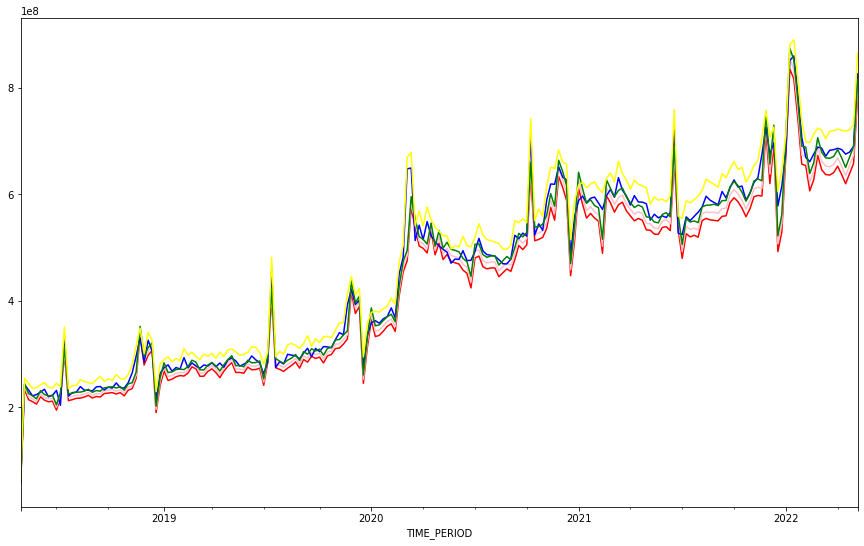

In [18]:
# Visualization

dategroup4 = dfc.groupby('TIME_PERIOD').sum()

dategroup4.index= pd.to_datetime(dategroup4.index, format='%Y-%m-%d')

fig, ax = plt.subplots(figsize=(15,9))
# dategroup['netasset'].plot(ax=ax[0],color='red')
# dategroup['asset'].plot(ax=ax[1],color='blue')
# dategroup['liab'].plot(ax=ax[2],color='green')
# ax[0].set_title('Net Asset', fontsize=10); 
# ax[1].set_title('Asset', fontsize=10)
# ax[2].set_title('Liability', fontsize=10)

dategroup4['Net_GMS'].plot(color='Red')
dategroup4['DDAA_SHIP_GMS'].plot(color='Pink')
dategroup4['DDAA_ORDER_GMS'].plot(color='blue')
dategroup4['DDAA_GROSS_SHIP_GMS'].plot(color='green')
dategroup4['DDAA_GROSS_ORDER_GMS'].plot(color='yellow')

In [19]:
# 
from sklearn.preprocessing import OneHotEncoder

dategroup4['date'] = pd.to_datetime(dategroup4.index, format='%Y-%m-%d')
dategroup4['month'] = pd.DatetimeIndex(dategroup4.date).month

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df1 = pd.DataFrame(encoder.fit_transform(dategroup4[['month']]).toarray()).rename(columns={0: "Jan", 1: "Feb", 2 : "Mar", 3 :"Apr", 4: "May",5: "Jun",6:"Jul",7:"Aug",8:"Sep",9:"Oct",10:"Nov",11:"Dec"}) 

encoder_df1
encoder_df1.index = dategroup4.index
#merge one-hot encoded columns back with original DataFrame
dategroup4_encode = dategroup4.join(encoder_df1).drop(columns = ['month','date'])
                        
dategroup4_encode.head()

,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_ORDER_UNITS,DDAA_GROSS_SHIP_GMS,DDAA_GROSS_SHIP_UNITS,Net_GMS,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,,,
2018-04-30,6.076716e+07,4305143.0,5.666001e+07,4035078.0,6.205712e+07,1.424289e+06,6.418709e+07,4521723.0,5.809373e+07,4047823.0,5.523572e+07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-07,2.430004e+08,16230628.0,2.392603e+08,16217982.0,2.472773e+08,5.578258e+06,2.549325e+08,16977779.0,2.448712e+08,16267065.0,2.336820e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-14,2.329231e+08,16169539.0,2.204322e+08,15435293.0,2.382826e+08,5.687746e+06,2.450477e+08,16923265.0,2.261549e+08,15482504.0,2.147445e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-21,2.217966e+08,15342067.0,2.163022e+08,15213419.0,2.268177e+08,5.508574e+06,2.354871e+08,16209189.0,2.218424e+08,15256888.0,2.107936e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-28,2.242494e+08,15630492.0,2.113801e+08,14973860.0,2.289776e+08,5.008192e+06,2.373821e+08,16465498.0,2.164167e+08,15014312.0,2.063719e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Time Series Analysis

1. ARIMA
2. SARIMA
3. VARIMA

### Stationarity Test - Unit Root Tests

In [ ]:
#  ADF Test
print('\nDDAA_SHIP_GMS: Stationarity test 1')
result = adfuller(dategroup.DDAA_SHIP_GMS.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


# KPSS Test
result = kpss(dategroup.DDAA_SHIP_GMS.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    

For DDAA_SHIP_GMS:

ADF test: Since p-value is larger than 0.1, we cannot reject the null hypothesis that there is a unit root/data is non-stationary.

KPSS test: Since p-value is equal to 0.1, we cannot reject the null hypothesis at 10% level that the data is stationary. 

Both tests indicate the original DDAA_SHIP_GMS time-series data is non-stationary.

In [ ]:
#  ADF Test
print('\nDDAA_SHIP_GMS: Stationarity test 1')
result = adfuller(dategroup4.DDAA_SHIP_GMS.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


# KPSS Test
result = kpss(dategroup4.DDAA_SHIP_GMS.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    

NA consumables weekly data originaly is not stationary. Need to differencing to eliminate trend and seaonal components.

### Detrend - two methods

#### Method 1: Subtract the line of best fit

In [ ]:
# Method 1 - Using scipy: Subtract the line of best fit
from scipy import signal
detrended1 = signal.detrend(dategroup.DDAA_SHIP_GMS.values)

f = plt.figure()
plt.plot(detrended1)
plt.title('DDAA_SHIP_GMS detrended by subtracting the least squares fit', fontsize=10)

After detrending, DDAA_SHIP_GMS time-series data has relatively constant shape, trend component has succesfully been removed. Also suggests there is no parabola in the residuals.

In [ ]:

# ADF Test
print('DDAA_SHIP_GMS: Stationarity test 2')
result = adfuller(detrended1, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(detrended1, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')



For DDAA_SHIP_GMS:

ADF test: Since p-value is larger than 0.1, we cannot reject the null hypothesis that there is a unit root/data is non-stationary.

KPSS test: Since p-value is equal to 0.1, we cannot reject the null hypothesis at 10% level that the data is stationary. This shows that detrending imporves stationarity of DDAA_SHIP_GMS data. 

However, substracting best fit result is not so satisfying to achieve stationary condition.

### Method2: Multiplicative or Additive decompose (compare)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(dategroup.DDAA_SHIP_GMS, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(dategroup.DDAA_SHIP_GMS, model='additive', extrapolate_trend='freq')

# Plot
fig = plt.figure()
fig.set_figheight(20) # optional setting the height of the image
fig.set_figwidth(20) # optional setting the width of the image

# fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
plt.rcParams.update({'figure.figsize': (10,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15)

result_add.plot().suptitle('Additive Decompose', fontsize=15)
plt.show()


For DDAA_SHIP_GMS data, we choose Multiplicative Decompose method because the magnitude of the seasonal pattern in the data depends on the magnitude of the data, and residuals are less vary with the level of the time series compared to additive method.

In [ ]:
# Method2: Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(2,figsize=(15,7),sharex=True)

# Multiplicative Decomposition 
result_mul = seasonal_decompose(dategroup.DDAA_SHIP_GMS, model='multiplicative', extrapolate_trend='freq')

detrended_multi = dategroup.DDAA_SHIP_GMS.values / result_mul.trend
detrended_multi.plot(ax=ax[0],color='blue')
ax[0].set_title('DDAA_SHIP_GMS detrended by dividing the trend component', fontsize=16); 

# Additive Decomposition
result_add = seasonal_decompose(dategroup.DDAA_SHIP_GMS, model='additive', extrapolate_trend='freq')

detrended_addi = dategroup.DDAA_SHIP_GMS.values - result_add.trend
detrended_addi.plot(ax=ax[1],color='red')
ax[1].set_title('DDAA_SHIP_GMS detrended by subtracting the trend component', fontsize=16); 

In [ ]:
# Multiplicative
# ADF Test
print('DDAA_SHIP_GMS: Stationarity test 3 - Multiplicative')
result = adfuller(detrended_multi, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(detrended_multi, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# Additive    
# ADF Test
print('\nDDAA_SHIP_GMS: Stationarity test 3 - Additive')
result = adfuller(detrended_addi, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(detrended_addi, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


Multiplicative is better than additive in terms of ADF stats, and is better than substracting best fit method.

### Deseasonalize

In [ ]:
# Time Series Decomposition

# result_mul = seasonal_decompose(dategroup.netasset, model='multiplicative', extrapolate_trend='freq')
result_mul = seasonal_decompose(detrended_multi, model='multiplicative', freq=4)
# Deseasonalize Net Asset
# deseasonalizedNet = detrended12.tolist() - result_mul.seasonal
deseasonalizedNet = detrended_multi.tolist() / result_mul.seasonal
# Plot
fig, ax = plt.subplots(1,figsize=(15,4),sharex=False)
plt.plot(deseasonalizedNet)
plt.title('DDAA_SHIP_GMS', fontsize=16)
plt.plot()


After both detrending and deseasonalizing, DDAA_SHIP_GMS shows constant shape acroos times. DDAA_SHIP_GMS still persists seasonality, which could be used for seasonal ARIMA model.

In [ ]:
# ADF Test
print('\nDDAA_SHIP_GMS: Stationarity test 4')
result = adfuller(deseasonalizedNet, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(deseasonalizedNet, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

DDAA_SHIP_GMS has much improvement after deseasonalizing, and achieves more stationarity. This is consist with the cyclic pattern of DDAA_SHIP_GMS. Now we can use DDAA_SHIP_GMS for prediction.

### Autocorrelation & Partial Autocorrelation

In [ ]:
# Net Asset after detrending 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(detrended_multi.tolist(), lags=50, ax=axes[0])
plot_pacf(detrended_multi.tolist(), lags=50, ax=axes[1])


In [ ]:
# Net Asset after detrending and deseasonalizing
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(deseasonalizedNet.tolist(), lags=50, ax=axes[0])
plot_pacf(deseasonalizedNet.tolist(), lags=50, ax=axes[1])


The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed, only describes the direct relationship between an observation and its lag.

Autocorrelation displays a sharp cutoff after lag3, thus we can consider adding MA term, q=3.
Partial Autocorrelation displays rare variation around zero, thus we don't need to add AR term, p=0.

### Method 3: Differencing


In [ ]:

# dep: Differencing once results in stationary condition
Diff_1 = dategroup.DDAA_SHIP_GMS.diff().dropna()
# depff = depf.diff().dropna()
# eeffrf = eeffr.diff().dropna()
# eeffrff = eeffrf.diff().dropna()

print('dep: Stationarity test - Differencing once')
result = adfuller(Diff_1, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(Diff_1, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# # eeffr: Differencing once results in stationary condition
# # ADF Test
# print('\neeffr: Stationarity test 5 - Differencing once')
# result = adfuller(eeffrf, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# # KPSS Test
# result = kpss(eeffrf, regression='c')
# print('\nKPSS Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# for key, value in result[3].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# dep: Stationarity test 5 - Differencing twice

In [ ]:
# Net Asset after detrending and deseasonalizing
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(Diff_1.tolist(), lags=50, ax=axes[0])
plot_pacf(Diff_1.tolist(), lags=50, ax=axes[1])


In [ ]:
# dep: Differencing twice results in stationary condition
Diff_2 = Diff_1.diff().dropna()
# depff = depf.diff().dropna()
# eeffrf = eeffr.diff().dropna()
# eeffrff = eeffrf.diff().dropna()

print('dep: Stationarity test - Differencing twice')
result = adfuller(Diff_2, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(Diff_2, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

In [ ]:
# Net Asset after detrending and deseasonalizing
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(Diff_2.tolist(), lags=50, ax=axes[0])
plot_pacf(Diff_2.tolist(), lags=50, ax=axes[1])


After twice differencing, Autocorrelation suggests MA term q=0. 

Partial Autocorrelation shows constant in range after 7, so choose p=7.

#### Sum of manufacturers

In [ ]:
# dep: Differencing once results in stationary condition
Diff_1sum = dategroup2.DDAA_SHIP_GMS.diff().dropna()
# depff = depf.diff().dropna()
# eeffrf = eeffr.diff().dropna()
# eeffrff = eeffrf.diff().dropna()

print('dep: Stationarity test - Differencing once')
result = adfuller(Diff_1sum, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(Diff_1sum, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# # eeffr: Differencing once results in stationary condition
# # ADF Test
# print('\neeffr: Stationarity test 5 - Differencing once')
# result = adfuller(eeffrf, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# # KPSS Test
# result = kpss(eeffrf, regression='c')
# print('\nKPSS Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# for key, value in result[3].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# dep: Stationarity test 5 - Differencing twice

In [ ]:
# Net Asset after detrending and deseasonalizing
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(Diff_1sum.tolist(), lags=50, ax=axes[0])
plot_pacf(Diff_1sum.tolist(), lags=50, ax=axes[1])


In [ ]:
# dep: Differencing twice results in stationary condition
Diff_2sum = Diff_1sum.diff().dropna()
# depff = depf.diff().dropna()
# eeffrf = eeffr.diff().dropna()
# eeffrff = eeffrf.diff().dropna()

print('dep: Stationarity test - Differencing twice')
result = adfuller(Diff_2sum, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(Diff_2sum, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

In [ ]:
# Net Asset after detrending and deseasonalizing
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(Diff_2sum.tolist(), lags=50, ax=axes[0])
plot_pacf(Diff_2sum.tolist(), lags=50, ax=axes[1])


If sum all manufacturers:

After twice differencing, Autocorrelation suggests MA term q=0.

Partial Autocorrelation shows constant in range after 7, so choose p=7.


#### Sum of manufactureres, weekly level

In [ ]:
# dep: Differencing once results in stationary condition
# Diff_1sumweek = dategroup3.DDAA_SHIP_GMS.diff().dropna()
# depff = depf.diff().dropna()
# eeffrf = eeffr.diff().dropna()
# eeffrff = eeffrf.diff().dropna()

print('dep: Stationarity test - Differencing once')
result = adfuller(dategroup3.DDAA_SHIP_GMS, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(dategroup3.DDAA_SHIP_GMS, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# # eeffr: Differencing once results in stationary condition
# # ADF Test
# print('\neeffr: Stationarity test 5 - Differencing once')
# result = adfuller(eeffrf, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# # KPSS Test
# result = kpss(eeffrf, regression='c')
# print('\nKPSS Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# for key, value in result[3].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# dep: Stationarity test 5 - Differencing twice

In [ ]:
# Net Asset after detrending and deseasonalizing
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(dategroup3.DDAA_SHIP_GMS.tolist(), lags=10, ax=axes[0])
plot_pacf(dategroup3.DDAA_SHIP_GMS.tolist(), lags=10, ax=axes[1])

In [ ]:
# dep: Differencing once results in stationary condition
Diff_1sumweek = dategroup3.DDAA_SHIP_GMS.diff().dropna()
# depff = depf.diff().dropna()
# eeffrf = eeffr.diff().dropna()
# eeffrff = eeffrf.diff().dropna()

print('dep: Stationarity test - Differencing once')
result = adfuller(Diff_1sumweek, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(Diff_1sumweek, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# # eeffr: Differencing once results in stationary condition
# # ADF Test
# print('\neeffr: Stationarity test 5 - Differencing once')
# result = adfuller(eeffrf, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# # KPSS Test
# result = kpss(eeffrf, regression='c')
# print('\nKPSS Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# for key, value in result[3].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# dep: Stationarity test 5 - Differencing twice

In [ ]:
# Net Asset after differencing once
plot_acf(Diff_1sumweek.tolist(), lags=10, ax=axes[0])
plot_pacf(Diff_1sumweek.tolist(), lags=10, ax=axes[1])

In [ ]:
dategroup3.DDAA_SHIP_GMS.mean()

In [ ]:
import statistics

print("Variance of sample set is % s"
      %(statistics.variance(dategroup3.DDAA_SHIP_GMS)))

### NA Consumables - weekly

In [20]:
# dep: Differencing once results in stationary condition
Diff_dfc = dategroup4_encode.DDAA_ORDER_GMS.diff().dropna()
# Diff_ogms = dategroup4.DDDAA_ORDER_GMS.diff().dropna()
# Diff_sunit = dategroup4.DDAA_SHIP_UNITS.diff().dropna()
# Diff_ounit= dategroup4.TOTAL_ORDERED_UNITS.diff().dropna()
# Diff_refund= dategroup4.DDAA_REFUNDED_AMOUNT.diff().dropna()
# Diff_sales = dategroup4.TOTAL_ORDERED_PROD_SALES_AMT.diff().dropna()
# Diff_grosgms = dategroup4.DDAA_GROSS_SHIP_GMS.diff().dropna()
# Diff_groogms = dategroup4.DDAA_GROSS_ORDER_GMS.diff().dropna()


print('dep: Stationarity test - Differencing once')
result = adfuller(Diff_dfc, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(Diff_dfc, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    

dep: Stationarity test - Differencing once
ADF Statistic: -8.871720997723473
p-value: 1.3921772830453835e-14
Critial Values:
   1%, -3.462818103072159
Critial Values:
   5%, -2.8758145932936805
Critial Values:
   10%, -2.574378674548251

KPSS Statistic: 0.069311
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


After one differencing, ADF test p value less than 0.05. So data is stationary now. 

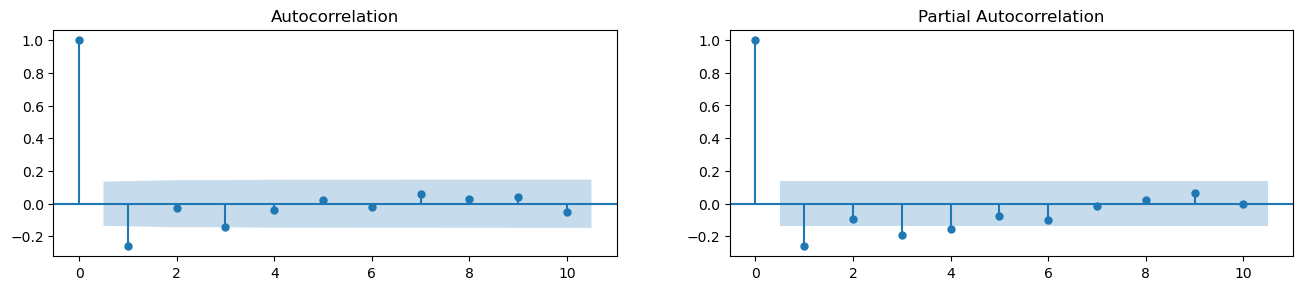

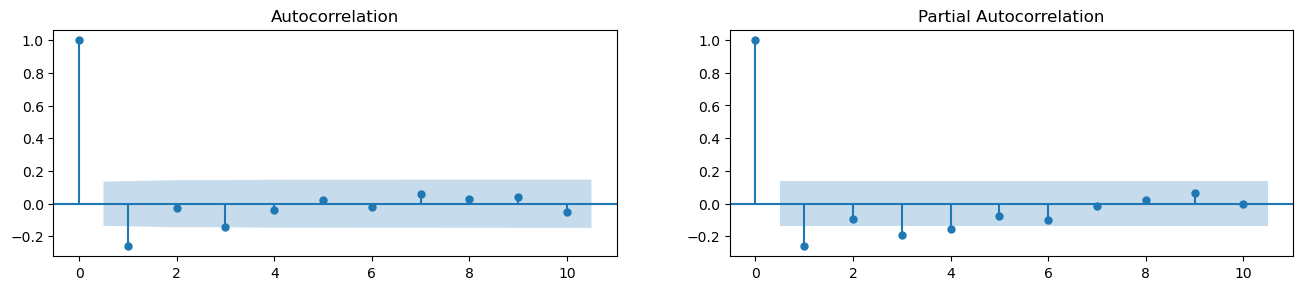

In [21]:
# Net Asset after diff once
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(Diff_dfc.tolist(), lags=10, ax=axes[0])
plot_pacf(Diff_dfc.tolist(), lags=10, ax=axes[1])

## ARIMA Model - Seasonal

In [20]:
print(Diff_2sum.to_frame().reset_index().RECORD_DAY.max() - Diff_2sum.to_frame().reset_index().RECORD_DAY.min())
print(Diff_2sum.to_frame().reset_index().RECORD_DAY.max())
print(Diff_2sum.to_frame().reset_index().RECORD_DAY.min())

NameError: name 'Diff_2sum' is not defined

In [21]:
# choose last 20% as test set, first 80% as training set
train_st = Diff_2sum.iloc[:-32]
test_st =  Diff_2sum.iloc[-32:]

NameError: name 'Diff_2sum' is not defined

In [22]:
train_st

NameError: name 'train_st' is not defined

In [23]:
test_st

NameError: name 'test_st' is not defined

In [ ]:
import itertools
import statsmodels.api as sm
# Define the p, d and q parameters to take any value between 0 and 3
p = range(0, 7)
d = range(2, 3)
q = range(0, 7)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


In [ ]:
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages
y=train_st

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
# SARIMA(0, 1, 3)x(0, 0, 0, 4) yields lowest AIC

import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages
y=train_st

sarima_model = sm.tsa.statespace.SARIMAX(y,
                                order=(7, 2, 0),
                                seasonal_order=(0, 0, 0, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarima_fit = sarima_model.fit()

print(sarima_fit.summary().tables[0])
print(sarima_fit.summary().tables[1])


In [ ]:
# Prediction results
pred = sarima_fit.get_forecast('2018-10-15')
pred_ci = pred.conf_int()
pred_ci


In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


y_forecasted = pred.predicted_mean
mse = ((y_forecasted - test_st) ** 2).mean()
mae = abs(y_forecasted - test_st).mean()
mape = mape(test_st,y_forecasted)             
asmape = asmape(test_st, y_forecasted)    
                   
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

In [ ]:
y_forecasted

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(mean_squared_error(y_forecasted, test_st)) # MSE

print(mean_squared_error(y_forecasted, test_st,squared=False))    # RMSE

print(mean_absolute_error(y_forecasted, test_st)) # MAE


In [ ]:
# 1-step ahead forecast
# Results visualization
ax = y['2018':].plot(label='observed',figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('DDAA_SHIP_GMS')
plt.legend()

plt.show()

#### NA Consumables weekly


In [22]:
print(Diff_dfc.to_frame().reset_index().TIME_PERIOD.max() - Diff_dfc.to_frame().reset_index().TIME_PERIOD.min())
print(Diff_dfc.to_frame().reset_index().TIME_PERIOD.max())
print(Diff_dfc.to_frame().reset_index().TIME_PERIOD.min())
print(len(Diff_dfc.index))
# after one differencing, number of weeks reduce by 1

1463 days 00:00:00
2022-05-09 00:00:00
2018-05-07 00:00:00
210


In [23]:
# choose last 20% as test set, first 80% as training set
# train_stc = pd.concat([Diff_dfc.iloc[:-42], dategroup4_encode[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']].iloc[:-42]], axis = 1).dropna()
# test_stc =  pd.concat([Diff_dfc.iloc[-42:], dategroup4_encode[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']].iloc[-42:]], axis = 1).dropna()

train_stc = dategroup4_encode[['DDAA_ORDER_GMS','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']].iloc[:-42]
test_stc =  dategroup4_encode[['DDAA_ORDER_GMS','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']].iloc[-42:]

In [24]:
Diff_dfc

TIME_PERIOD
2018-05-07    1.822332e+08
2018-05-14   -1.007727e+07
2018-05-21   -1.112654e+07
2018-05-28    2.452865e+06
2018-06-04    4.707262e+06
                  ...     
2022-04-11   -2.293880e+06
2022-04-18   -8.718163e+06
2022-04-25    3.941558e+06
2022-05-02    1.074879e+07
2022-05-09    1.358518e+08
Name: DDAA_ORDER_GMS, Length: 210, dtype: float64

In [25]:
train_stc

,DDAA_ORDER_GMS,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
TIME_PERIOD,,,,,,,,,,,,,
2018-04-30,6.076716e+07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-07,2.430004e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-14,2.329231e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-21,2.217966e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-28,2.242494e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-21,7.216875e+08,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-28,5.268874e+08,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-05,5.243026e+08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
test_stc

,DDAA_ORDER_GMS,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
TIME_PERIOD,,,,,,,,,,,,,
2021-07-26,5.582543e+08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-08-02,5.662622e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-09,5.758626e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-16,5.961996e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-23,5.887899e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-30,5.845411e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-09-06,5.803100e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-09-13,6.050560e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2021-09-20,5.932375e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### SRIMAX
include month as categorical variables to suggest seasonality, one hot encoding

In [29]:
import itertools
import statsmodels.api as sm
# Define the p, d and q parameters to take any value between ranges
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 0, 2, 52)
SARIMAX: (0, 0, 2) x (0, 0, 3, 52)
SARIMAX: (0, 0, 2) x (0, 0, 4, 52)


In [ ]:
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages
y=train_stc.DDAA_ORDER_GMS

exog_vars = train_stc[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
exog_vars_test = test_stc[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

results_aic = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            exog = exog_vars,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            results_aic[param, param_seasonal]=results.aic
            
        except:
            continue
            
            

In [ ]:
min(results_aic, key=results_aic.get)

In [30]:
# SARIMA(0, 1, 3)x(0, 0, 0, 4) yields lowest AIC

import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages
y=train_stc.DDAA_ORDER_GMS

exog_vars = train_stc[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
exog_vars_test = test_stc[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]


sarima_model = sm.tsa.statespace.SARIMAX(y,
                                exog = exog_vars,
                                order=(2, 1, 1),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarima_fit = sarima_model.fit()

print(sarima_fit.summary().tables[0])
print(sarima_fit.summary().tables[1])


                                      SARIMAX Results                                      
Dep. Variable:                      DDAA_ORDER_GMS   No. Observations:                  169
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 52)   Log Likelihood               -2171.966
Date:                             Thu, 19 May 2022   AIC                           4377.931
Time:                                     15:55:22   BIC                           4424.447
Sample:                                 04-30-2018   HQIC                          4396.809
                                      - 07-19-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Jan        -5.178e+06   1.28e-10  -4.05e+16      0.000   -5.18e+06   -5.18e+06
Feb        -9.259e+06    1.

In [31]:
# Prediction results
pred = sarima_fit.get_forecast('2022-05-09',exog=exog_vars_test)
pred_ci = pred.conf_int()
final_prediction_srimax = pred_ci.join(pred.predicted_mean).join(test_stc.DDAA_ORDER_GMS).rename(columns = {'DDAA_ORDER_GMS':'Actual'})
final_prediction_srimax

,lower DDAA_ORDER_GMS,upper DDAA_ORDER_GMS,predicted_mean,Actual
2021-07-26,4.646646e+08,6.364885e+08,5.505765e+08,5.582543e+08
2021-08-02,4.484073e+08,6.454329e+08,5.469201e+08,5.662622e+08
2021-08-09,4.392465e+08,6.533313e+08,5.462889e+08,5.758626e+08
2021-08-16,4.287791e+08,6.577720e+08,5.432755e+08,5.961996e+08
2021-08-23,4.182289e+08,6.610583e+08,5.396436e+08,5.887899e+08
2021-08-30,4.115689e+08,6.674588e+08,5.395139e+08,5.845411e+08
2021-09-06,4.070896e+08,6.753998e+08,5.412447e+08,5.803100e+08
2021-09-13,4.219695e+08,7.021490e+08,5.620593e+08,6.050560e+08
2021-09-20,4.132775e+08,7.048434e+08,5.590605e+08,5.932375e+08
2021-09-27,4.126922e+08,7.152160e+08,5.639541e+08,6.124275e+08


In [32]:
len(pred.predicted_mean)

42

In [33]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


y_forecasted = pred.predicted_mean
mse = ((y_forecasted - test_stc.DDAA_ORDER_GMS) ** 2).mean()
mae = abs(y_forecasted - test_stc.DDAA_ORDER_GMS).mean()
mape = mape(test_stc.DDAA_ORDER_GMS,y_forecasted)             
asmape = asmape(test_stc.DDAA_ORDER_GMS, y_forecasted)    
                   
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

The Mean Squared Error is 1.0424411128967252e+16
The Root Mean Squared Error is 102100005.53
The MAE is 82621418
The MAPE is 12
The ASMAPE is 12


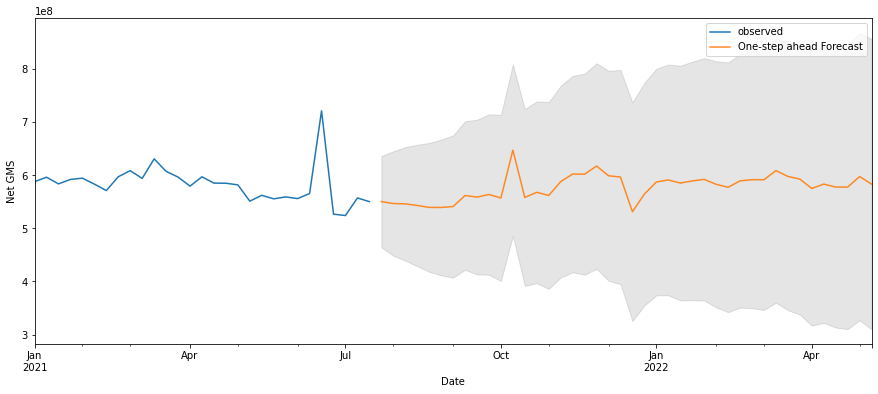

In [34]:
# 1-step ahead forecast
# Results visualization
ax = y['2021':].plot(label='observed',figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Net GMS')
plt.legend()

plt.show()

In [116]:
# save results as csv
final_prediction_srimax.to_csv('SARIMAX_prediction_NAconsumables.csv',index=True)

#### Take log to make positive prediction

In [85]:
y_log = np.log10(train_stc.DDAA_ORDERED_GMS)
y_log

AttributeError: 'DataFrame' object has no attribute 'DDAA_ORDERED_GMS'

AttributeError: 'DataFrame' object has no attribute 'DDAA_ORDERED_GMS'

In [65]:
train_stc

,Net_GMS,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
TIME_PERIOD,,,,,,,,,,,,,
2018-05-07,1.784463e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-14,-1.893750e+07,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-21,-3.950858e+06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-28,-4.421726e+06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-04,1.368184e+07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-21,1.306344e+08,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-28,-1.283677e+08,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-05,-5.439477e+07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Test prediction accuracy by splitting data
from statsmodels.tsa.statespace.sarimax import SARIMAX
pred_train = sarima_fit.get_forecast(steps=32)
pred_citrain = pred_train.conf_int()

sarima_model = SARIMAX(train_st, order=(7, 2, 0), seasonal_order=(0, 0, 0, 4), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction("2018-09-14", "2018-10-15")
predicted_means = pred_train.predicted_mean + Diff_2sum.iloc[-36:-1].rolling(4).mean().dropna().values
predicted_intervals = pred_train.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower DDAA_SHIP_GMS'] + Diff_2sum.iloc[-36:-1].rolling(4).mean().dropna().values
upper_bounds = predicted_intervals['upper DDAA_SHIP_GMS'] + Diff_2sum.iloc[-36:-1].rolling(4).mean().dropna().values

sarima_rmse = np.sqrt(np.mean(np.square(test_st.values - pred_train.predicted_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(Diff_2sum.index[100:-32], Diff_2sum.values[100:-32]);
ax.plot(test_st.index, test_st.values + Diff_2sum.iloc[-36:-1].rolling(4).mean().dropna().values, label='truth');
ax.plot(test_st.index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sarima_rmse,sarima_fit.aic));
ax.fill_between(test_st.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");


### Auto ARIMA

In [35]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 20.6 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [36]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

automodel = pm.auto_arima(dategroup2.DDAA_SHIP_GMS[:-32], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(automodel.summary())

NameError: name 'dategroup2' is not defined

In [ ]:
train_day = dategroup2.DDAA_SHIP_GMS[:-32]
test_day =  dategroup2.DDAA_SHIP_GMS[-32:]
automodel.fit(train_day)

forecast_day = automodel.predict(n_periods=len(test_day))
forecast_day = pd.DataFrame(forecast_day,index = test_day.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train_day, label='Train')
plt.plot(test_day, label='Valid')
plt.plot(forecast_day, label='Prediction')
plt.show()


In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(forecast_day, test_day)
mae = mean_absolute_error(forecast_day ,test_day)
mape = mape(test_day, forecast_day)      
asmape = asmape(test_day, forecast_day)
            
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

In [ ]:
## weekly data auto arima
print(len(dategroup3.index))
dategroup3.DDAA_SHIP_GMS.plot()

In [ ]:
## weekly data
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

automodel2 = pm.auto_arima(dategroup3.DDAA_SHIP_GMS[:-5], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(automodel2.summary())

In [ ]:
train_week = dategroup3.DDAA_SHIP_GMS[:-5]
test_week =  dategroup3.DDAA_SHIP_GMS[-5:]
automodel2.fit(train_week)

forecast = automodel2.predict(n_periods=len(test_week))
forecast = pd.DataFrame(forecast,index = test_week.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train_week, label='Train')
plt.plot(test_week, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()


In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(forecast, test_week)
mae = mean_absolute_error(forecast ,test_week)
mape = mape(test_week, forecast)      
asmape = asmape(test_week, forecast)
            
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

In [ ]:
# Forecast
n_periods = 4
fitted, confint = automodel2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(dategroup3.index[-1], periods = n_periods, freq='W')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(dategroup3.DDAA_SHIP_GMS)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

#### NA Consumables - weekly
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [37]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

automodel = pm.auto_arima(dategroup4.DDAA_ORDER_GMS[:-42], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=52,             # frequency of series, 52 weeks a year
                      d=None,           # let model determine 'd'
                      seasonal=True,    # include Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(automodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=6424.775, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=6434.683, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=6405.881, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=6400.114, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=6433.264, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=6410.604, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=6401.480, Time=1.40 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=6400.252, Time=2.37 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=6399.595, Time=0.53 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=6401.500, Time=2.57 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=7.72 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=6422.884, Time=0.40 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=6401.189, Time=0.80 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=6401.579, Time=0.70 sec
 ARIMA(1,1,2)(1,0,0)[52]

Auto ARIMA choose best model ARIMA(1,1,1)(1,0,0)[52] for DDAA_ORDER_GMS

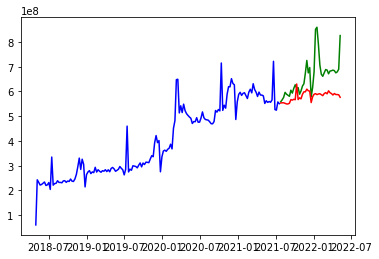

In [38]:
train_nac= dategroup4.DDAA_ORDER_GMS[:-42]
test_nac =  dategroup4.DDAA_ORDER_GMS[-42:]
automodel.fit(train_nac)

forecast_nac = automodel.predict(n_periods=len(test_nac))
forecast_nac = pd.DataFrame(forecast_nac,index = test_nac.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train_nac, label='Train',color = 'blue')
plt.plot(test_nac, label='Valid',color = 'green')
plt.plot(forecast_nac, label='Prediction', color = 'red')
plt.show()


In [39]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(forecast_nac, test_nac)
mae = mean_absolute_error(forecast_nac ,test_nac)
mape = mape(test_nac, forecast_nac)      
asmape = asmape(test_nac, forecast_nac)
            
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

The Mean Squared Error is 1.0115890647831176e+16
The Root Mean Squared Error is 100577784.07
The MAE is 78530496
The MAPE is 12
The ASMAPE is 12


In [40]:
y_forec, conf_int  = automodel.predict(42,return_conf_int=True,alpha=0.1)
forecast_nac = pd.DataFrame(y_forec,index = test_nac.index,columns=['Prediction'])
ci_nac = pd.DataFrame(conf_int,index = test_nac.index,columns=['Lower_ORDER_GMS','Higher_ORDER_GMS'])

In [41]:
train_nac

TIME_PERIOD
2018-04-30    6.076716e+07
2018-05-07    2.430004e+08
2018-05-14    2.329231e+08
2018-05-21    2.217966e+08
2018-05-28    2.242494e+08
                  ...     
2021-06-21    7.216875e+08
2021-06-28    5.268874e+08
2021-07-05    5.243026e+08
2021-07-12    5.574638e+08
2021-07-19    5.504877e+08
Name: DDAA_ORDER_GMS, Length: 169, dtype: float64

In [42]:
final_prediction = forecast_nac.join(ci_nac)
final_prediction.index = pd.to_datetime(final_prediction.index, format='%Y-%m-%d')

s3output = final_prediction.join(pd.DataFrame(test_nac)).rename(columns = {'DDAA_ORDER_GMS':'Actual'})

s3output

,Prediction,Lower_ORDER_GMS,Higher_ORDER_GMS,Actual
TIME_PERIOD,,,,
2021-07-26,5.532859e+08,4.817706e+08,6.248012e+08,5.582543e+08
2021-08-02,5.541995e+08,4.713545e+08,6.370446e+08,5.662622e+08
2021-08-09,5.540210e+08,4.644528e+08,6.435892e+08,5.758626e+08
2021-08-16,5.519722e+08,4.568553e+08,6.470891e+08,5.961996e+08
2021-08-23,5.494327e+08,4.492421e+08,6.496234e+08,5.887899e+08
2021-08-30,5.493469e+08,4.443690e+08,6.543249e+08,5.845411e+08
2021-09-06,5.523099e+08,4.427641e+08,6.618556e+08,5.803100e+08
2021-09-13,5.669832e+08,4.530553e+08,6.809112e+08,6.050560e+08
2021-09-20,5.648694e+08,4.467223e+08,6.830164e+08,5.932375e+08


In [68]:
train_output = pd.DataFrame()
train_output['Actual'] = pd.DataFrame(train_nac).DDAA_ORDER_GMS
train_output['Prediction'] = pd.DataFrame(train_nac).DDAA_ORDER_GMS
train_output['Lower_ORDER_GMS'] = np.zeros(len(train_nac))
train_output['Higher_ORDER_GMS'] = np.zeros(len(train_nac))

autoarima_output = pd.concat([s3output, train_output], axis=0).sort_values(by=['TIME_PERIOD'])
autoarima_output 

,Prediction,Lower_ORDER_GMS,Higher_ORDER_GMS,Actual
TIME_PERIOD,,,,
2018-04-30,6.076716e+07,0.000000e+00,0.000000e+00,6.076716e+07
2018-05-07,2.430004e+08,0.000000e+00,0.000000e+00,2.430004e+08
2018-05-14,2.329231e+08,0.000000e+00,0.000000e+00,2.329231e+08
2018-05-21,2.217966e+08,0.000000e+00,0.000000e+00,2.217966e+08
2018-05-28,2.242494e+08,0.000000e+00,0.000000e+00,2.242494e+08
...,...,...,...,...
2022-04-11,5.914214e+08,3.856242e+08,7.972186e+08,6.838331e+08
2022-04-18,5.875121e+08,3.793497e+08,7.956745e+08,6.751149e+08
2022-04-25,5.874194e+08,3.769184e+08,7.979205e+08,6.790565e+08


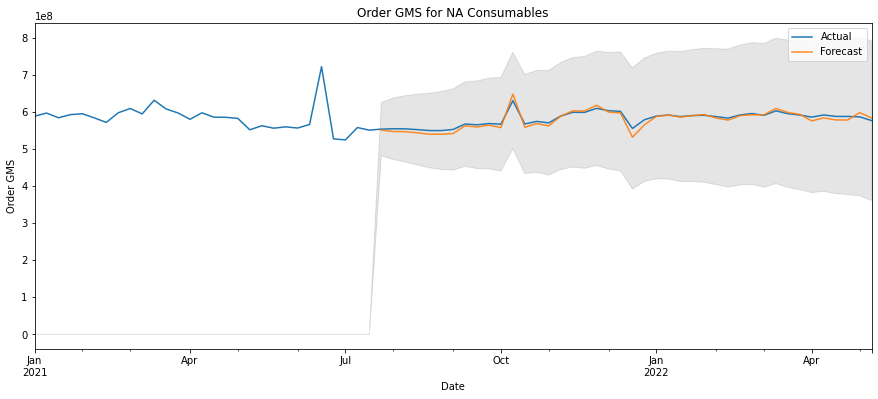

In [74]:
# Results visualization
ax = autoarima_output.Prediction['2021':].plot(label='Actual',figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

ax.fill_between(autoarima_output.index,
                autoarima_output.Lower_ORDER_GMS,
                autoarima_output.Higher_ORDER_GMS, color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Order GMS')
ax.set_title('Order GMS for NA Consumables')
plt.legend()

plt.show()

In [77]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(autoarima_output.Prediction, autoarima_output.Actual)
mae = mean_absolute_error(autoarima_output.Prediction, autoarima_output.Actual)
mape = mape(autoarima_output.Prediction, autoarima_output.Actual)      
asmape = asmape(autoarima_output.Prediction, autoarima_output.Actual)
            
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

The Mean Squared Error is 2013589607625163.0
The Root Mean Squared Error is 44873038.76
The MAE is 15631663
The MAPE is 3
The ASMAPE is 2


In [72]:
# save results as csv
s3output.to_csv('AutoARIMA_prediction_NAconsumables.csv',index=True)
autoarima_output.to_csv('AutoARIMA_Full_prediction_NAconsumables.csv',index=True)

## VARIMA
https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html

In [ ]:
# Granger Causality Test

from statsmodels.tsa.stattools import grangercausalitytests

variables=dategroup3.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(dategroup3[[row, col]], maxlag=7, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(7)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]
matrix

As all values are all below 0.05 except the diagonal, we could reject that the null hypothesis and this dataset is a good candidate of VectorARIMA modeling.

In [82]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in dategroup4.iteritems():
    adfuller_test(column, name=column.name)

 DDAA_ORDER_GMS : P-Value = 0.909 => Non-stationary.
 TOTAL_ORDERED_UNITS : P-Value = 0.974 => Non-stationary.
 DDAA_SHIP_GMS : P-Value = 0.911 => Non-stationary.
 DDAA_SHIP_UNITS : P-Value = 0.974 => Non-stationary.
 TOTAL_ORDERED_PROD_SALES_AMT : P-Value = 0.888 => Non-stationary.
 DDAA_REFUNDED_AMOUNT : P-Value = 0.786 => Non-stationary.
 DDAA_GROSS_ORDER_GMS : P-Value = 0.914 => Non-stationary.
 DDAA_GROSS_ORDER_UNITS : P-Value = 0.974 => Non-stationary.
 DDAA_GROSS_SHIP_GMS : P-Value = 0.912 => Non-stationary.
 DDAA_GROSS_SHIP_UNITS : P-Value = 0.974 => Non-stationary.
 Net_GMS : P-Value = 0.91 => Non-stationary.
 month : P-Value = 0.009 => Stationary. 
 date : P-Value = 0.999 => Non-stationary.


In [83]:
# Differencing
data_differenced = dategroup4[['DDAA_ORDER_GMS','TOTAL_ORDERED_UNITS','DDAA_SHIP_GMS','DDAA_SHIP_UNITS','TOTAL_ORDERED_PROD_SALES_AMT','DDAA_REFUNDED_AMOUNT','DDAA_GROSS_ORDER_GMS','DDAA_GROSS_SHIP_UNITS']].diff().dropna()
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)

 DDAA_ORDER_GMS : P-Value = 0.0 => Stationary. 
 TOTAL_ORDERED_UNITS : P-Value = 0.0 => Stationary. 
 DDAA_SHIP_GMS : P-Value = 0.0 => Stationary. 
 DDAA_SHIP_UNITS : P-Value = 0.0 => Stationary. 
 TOTAL_ORDERED_PROD_SALES_AMT : P-Value = 0.0 => Stationary. 
 DDAA_REFUNDED_AMOUNT : P-Value = 0.0 => Stationary. 
 DDAA_GROSS_ORDER_GMS : P-Value = 0.0 => Stationary. 
 DDAA_GROSS_SHIP_UNITS : P-Value = 0.0 => Stationary. 


In [84]:
# varima_data = pd.concat([dategroup4[['DDAA_SHIP_GMS','DDAA_ORDER_GMS','DDAA_REFUNDED_AMOUNT']], data_differenced], axis=1, join='inner')
# varima_data[:-5]
varima_data = data_differenced
varima_data

,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_SHIP_UNITS
TIME_PERIOD,,,,,,,,
2018-05-07,1.822332e+08,11925485.0,1.826002e+08,12182904.0,1.852202e+08,4.153969e+06,1.907454e+08,12219242.0
2018-05-14,-1.007727e+07,-61089.0,-1.882802e+07,-782689.0,-8.994716e+06,1.094884e+05,-9.884803e+06,-784561.0
2018-05-21,-1.112654e+07,-827472.0,-4.130030e+06,-221874.0,-1.146491e+07,-1.791718e+05,-9.560587e+06,-225616.0
2018-05-28,2.452865e+06,288425.0,-4.922108e+06,-239559.0,2.159931e+06,-5.003821e+05,1.894971e+06,-242576.0
2018-06-04,4.707262e+06,45031.0,1.426833e+07,726674.0,4.539653e+06,5.864976e+05,5.260040e+06,732158.0
...,...,...,...,...,...,...,...,...
2022-04-11,-2.293880e+06,-3816.0,-1.540231e+07,-498002.0,-6.502082e+05,1.258443e+05,-2.299407e+06,-498804.0
2022-04-18,-8.718163e+06,-1907425.0,-1.775025e+07,-2716454.0,-9.019712e+06,-3.815842e+05,-1.293413e+06,-2717516.0
2022-04-25,3.941558e+06,469785.0,1.913673e+07,1423752.0,4.495067e+06,2.782659e+05,2.068095e+06,1420426.0


In [85]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

mod = sm.tsa.VARMAX(varima_data[['DDAA_SHIP_GMS','DDAA_ORDER_GMS','DDAA_REFUNDED_AMOUNT','DDAA_SHIP_UNITS','TOTAL_ORDERED_UNITS']][:-5], order=(1,1,0))
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                                                     Statespace Model Results                                                                    
Dep. Variable:     ['DDAA_SHIP_GMS', 'DDAA_ORDER_GMS', 'DDAA_REFUNDED_AMOUNT', 'DDAA_SHIP_UNITS', 'TOTAL_ORDERED_UNITS']   No. Observations:                  205
Model:                                                                                                        VARMA(1,1)   Log Likelihood              -16941.269
                                                                                                             + intercept   AIC                          34022.538
Date:                                                                                                   Fri, 20 May 2022   BIC                          34255.149
Time:                                                                                                           02:40:41   HQIC                         34116.624
Sample:                     

In [127]:
y_forecasted  = res.predict('2022-05-09').DDAA_ORDER_GMS
# varima_data[['DDAA_SHIP_GMS','DDAA_ORDER_GMS']]
y_forecasted

2022-05-09    2.628509e+06
Freq: W-MON, Name: DDAA_ORDER_GMS, dtype: float64

In [133]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual),np.abs(pred)))) * 100


In [135]:
test_st

,DDAA_ORDER_GMS
TIME_PERIOD,
2022-05-09,1.358518e+08


In [78]:
test_st = varima_data[['DDAA_ORDER_GMS']][-1:]

mse = ((y_forecasted - test_st) ** 2).mean()
mae = abs(y_forecasted - test_st).mean()
mape = mape(test_st,y_forecasted)             
asmape = asmape(test_st, y_forecasted)    
                   
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

NameError: name 'varima_data' is not defined

In [ ]:
ax = res.impulse_responses(10, orthogonalized=True, impulse=[1, 0]).plot(figsize=(13,3))
ax.set(xlabel='t', title='GMS');

In [ ]:
import hana_ml
from hana_ml import dataframe
conn = dataframe.ConnectionContext('host', 'port', 'username', 'password')

In [ ]:
## Modeling
from hana_ml.algorithms.pal.tsa.vector_arima import VectorARIMA

vectorArima1 = VectorARIMA(order=(-1, 2, -1), model_type = 'VARMA', search_method='grid_search', output_fitted=True, max_p=5, max_q=5)
vectorArima1.fit(data=varima_data[:-5])

print(vectorArima1.model_.collect())
print(vectorArima1.fitted_.collect())
print(vectorArima1.model_.collect()['CONTENT_VALUE'][3])

In [ ]:
#pip install hana_ml

## Deploy

In [ ]:
arima_predictor = sarima_model.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
)

## DeepAR
reference: deepar_chicago_traffic_violations.ipynb sample notebook in sagemaker

In [ ]:
df1 = df[['DDAA_SHIP_GMS','DDAA_ORDER_GMS','DDAA_GROSS_SHIP_UNITS','TOTAL_ORDERED_UNITS','DDAA_REFUNDED_AMOUNT','RECORD_DAY','CHILD_MANUFACTURER_CODE']].set_index('RECORD_DAY').groupby('CHILD_MANUFACTURER_CODE')
df1.head()

In [ ]:
# convert daily to weekly for each manufacturer
from pandas.tseries.frequencies import to_offset

logic = {'DDAA_SHIP_GMS'  : 'sum',
         'DDAA_ORDER_GMS'  : 'sum',
         'DDAA_GROSS_SHIP_UNITS'   : 'sum',
         'TOTAL_ORDERED_UNITS' : 'sum',
         'DDAA_REFUNDED_AMOUNT' :'sum',}

# dfw2 = dfsub2.set_index('RECORD_DAY')
dfw2 = df1.resample('W').apply(logic).reset_index().set_index('RECORD_DAY')
dfw2.index -= to_offset("6D")
#alternative
#df.index = df.index - to_offset("6D")
dfw2.head()

In [ ]:
deepardata = dfw2[['CHILD_MANUFACTURER_CODE','DDAA_SHIP_GMS']].reset_index()
deepardata.tail(6)

In [ ]:
deepardata.dtypes

As described in Amazon SageMaker DeepAR input/output interface section, we will convert the data into array, and use 0 for the violation count when data for a given camera on a given date is not available. Using the Matplotlib library we display each camera location as a timeseries to visualize the data

In [ ]:
unique_manu = deepardata.CHILD_MANUFACTURER_CODE.unique()
idx = pd.date_range(deepardata.RECORD_DAY.min(), deepardata.RECORD_DAY.max())
number_of_manu = len(unique_manu)
print("Unique Manufacturers {}".format(number_of_manu))
print(
    "Minimum record week is {}, maximum record week is {}".format(
        deepardata.RECORD_DAY.min(), deepardata.RECORD_DAY.max()
    )
)


gms_list = []
for key in unique_manu:
    temp_df = deepardata[["RECORD_DAY", "DDAA_SHIP_GMS"]][deepardata.CHILD_MANUFACTURER_CODE == key]
    temp_df.set_index(["RECORD_DAY"], inplace=True)
    temp_df.index = pd.DatetimeIndex(temp_df.index)
    temp_df = temp_df.reindex(idx, fill_value=0)
    gms_list.append(temp_df["DDAA_SHIP_GMS"])

plt.figure(figsize=(12, 6), dpi=100, facecolor="w")
for key, manu in enumerate(unique_manu):
    plt.plot(gms_list[key], label=manu)

plt.ylabel("DDAA_SHIP_GMS")
plt.xlabel("Date")
plt.title("DDAA_SHIP_GMS across week")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=False, ncol=4)
plt.show()

We define prediction length as 5 weeks, and split the data with last 5 weeks of data as test data. We use rest of the data for training of the model. We can use the last 5 weeks of data to evaluate the accuracy of our trained model. We write the training and test data files in JSON format in the S3 bucket. 

In [ ]:
prediction_length = 5

bucket = 'sagemaker-ir2'
prefix = 'deepar'

s3_output_path = "{}/{}/output".format(bucket, prefix)
train_data_path = "s3://{}/{}/train/train.json".format(bucket, prefix)
test_data_path = "s3://{}/{}/test/test.json".format(bucket, prefix)

# Split the data for training and validation/hold out
gms_list_training = []
for i in gms_list:
    gms_list_training.append((i[:-prediction_length]))


def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))


with open("train.json", "w") as fp:
    for ts in gms_list_training:
        fp.write(series_to_jsonline(ts))
        fp.write("\n")
! aws s3 mv train.json $train_data_path

with open("test.json", "w") as fp:
    for ts in gms_list:
        fp.write(series_to_jsonline(ts))
        fp.write("\n")
! aws s3 mv test.json $test_data_path

In [ ]:
## Train

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker import image_uris


container = image_uris.retrieve(region=region, framework="forecasting-deepar")

deepar = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    use_spot_instances=True,  # use spot instances
    max_run=1800,  # max training time in seconds
    max_wait=1800,  # seconds to wait for spot instance
    output_path="s3://{}/{}".format(bucket, s3_output_path),
    sagemaker_session=sess,
)
freq = "D"
context_length = 30

deepar.set_hyperparameters(
    time_freq=freq, context_length=str(context_length), prediction_length=str(prediction_length)
)

hyperparameter_ranges = {
    "mini_batch_size": IntegerParameter(100, 400),
    "epochs": IntegerParameter(200, 400),
    "num_cells": IntegerParameter(30, 100),
    "likelihood": CategoricalParameter(["negative-binomial", "student-T"]),
    "learning_rate": ContinuousParameter(0.0001, 0.1),
}

objective_metric_name = "test:RMSE"

tuner = HyperparameterTuner(
    deepar,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=10,
    strategy="Bayesian",
    objective_type="Minimize",
    max_parallel_jobs=10,
    early_stopping_type="Auto",
)

s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/train/".format(bucket, prefix), content_type="json"
)
s3_input_test = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/test/".format(bucket, prefix), content_type="json"
)

tuner.fit({"train": s3_input_train, "test": s3_input_test}, include_cls_metadata=False)
tuner.wait()

In [ ]:
## Host

from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

best_tuning_job_name = tuner.best_training_job()
endpoint = tuner.deploy(
    initial_instance_count=1,
    endpoint_name=best_tuning_job_name,
    instance_type="ml.m4.xlarge",
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer(),
    wait=True,
)

In [ ]:
## Evaluate

class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args, serializer=IdentitySerializer(content_type="application/json"), **kwargs
        )

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be
        called before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the
        (optional) corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: 'utf-8')
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ['0.1', '0.5', '0.9'])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + x.index.freq for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df


predictor = DeepARPredictor(endpoint_name=endpoint.endpoint_name, sagemaker_session=sess)

In [ ]:
# daily frequency with context length 30
predictor.set_prediction_parameters(freq, prediction_length)
list_of_df = predictor.predict(gms_list_training[:5])
actual_data = gms_list[:5]
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6), dpi=75, facecolor="w")
    plt.ylabel("DDAA_SHIP_GMS")
    plt.xlabel("Date")
    plt.title("DDAA_SHIP_GMS:" + unique_manu[k])
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [ ]:
# weekly frequency with context length 5
predictor.set_prediction_parameters(freq, prediction_length)
list_of_df = predictor.predict(gms_list_training[:5])
actual_data = gms_list[:5]
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6), dpi=75, facecolor="w")
    plt.ylabel("DDAA_SHIP_GMS")
    plt.xlabel("Date")
    plt.title("DDAA_SHIP_GMS:" + unique_manu[k])
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [ ]:
# daily frequency with context length 5
predictor.set_prediction_parameters(freq, prediction_length)
list_of_df = predictor.predict(gms_list_training[:5])
actual_data = gms_list[:5]
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6), dpi=75, facecolor="w")
    plt.ylabel("DDAA_SHIP_GMS")
    plt.xlabel("Date")
    plt.title("DDAA_SHIP_GMS:" + unique_manu[k])
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [ ]:
list_of_df

In [ ]:
gms_list_training[:5]

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(abs(actual),abs(pred)))) * 100


In [ ]:


test_st = varima_data[['DDAA_SHIP_GMS','DDAA_ORDER_GMS']][-5:]

mse = ((y_forecasted - test_st) ** 2).mean()
mae = abs(y_forecasted - test_st).mean()
mape = mape(test_st,y_forecasted)             
asmape = asmape(test_st, y_forecasted)    
                   
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

In [ ]:
for k in range(len(list_of_df)):
    y_predict = list_of_df[k]["0.5"]
    print(y_predict)
#     print(y_predict)
    print(actual_data[k][-prediction_length - context_length :])

In [ ]:
gms_list

In [ ]:
import awswrangler as wr

df = wr.s3.read_csv(path="s3://sagemaker-ir2/ddaa_manubrandmerch_rollup/region=NA/")

In [ ]:
# show readme
# display(Markdown("README.md"))

# read the input file, and display sample rows/columns
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 50)
df = pd.read_csv(open(datafile, "rb"), encoding="utf-8")

# print first 10 lines to look at part of the dataset
df[["ADDRESS", "VIOLATION DATE", "VIOLATIONS"]][0:10]